<a href="https://colab.research.google.com/github/farenga/neuralODE/blob/main/pdetest_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchdiffeq

In [2]:
import os
import argparse
import time
import psutil
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from torchdiffeq import odeint

In [3]:
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [5]:
train_mat = scipy.io.loadmat('/content/S_train_20.mat')
params_train_mat = scipy.io.loadmat('/content/params_train_20.mat')
test_mat = scipy.io.loadmat('/content/S_test_20_extended.mat')
params_test_mat = scipy.io.loadmat('/content/params_test_20_extended.mat')

In [6]:
train_data = torch.tensor(train_mat['S'])
params_train_data = torch.tensor(params_train_mat['I'])
test_data = torch.tensor(test_mat['S'])
params_test_data = torch.tensor(params_test_mat['I'])

In [7]:
train_data = torch.transpose(train_data[:,:400],0, 1).unsqueeze(1)

In [8]:
train_data.shape

torch.Size([400, 1, 256])

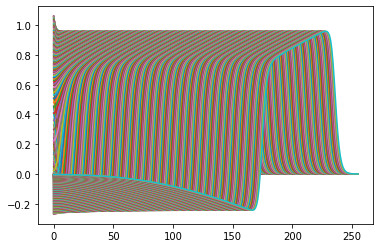

In [9]:
for i in range(0,400):
   plt.plot(train_data[i,:,:].flatten())
   #print(params_train_data[i])

In [10]:
data_size = train_data.shape[0]
print(data_size)
batch_time = 50
batch_size = 16
n_hidden = 50
method = 'dopri5'
test_freq = 50
epochs = 1000

400


In [11]:
def get_batch():
    batch_t = torch.arange(batch_time).float()
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time), batch_size, replace=False))
    
    batch_u0 = train_data[s,:,:].float()
    batch_u = torch.stack([train_data[s+i,:,:] for i in range(batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), s

In [12]:
def get_batch_test(t0,test_batch_time):
    batch_t = torch.arange(test_batch_time-t0).float()
    s = torch.tensor([t0])
    batch_u0 = train_data[s,:,:].float()
    batch_u = torch.stack([train_data[s+i,:,:] for i in range(test_batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), s

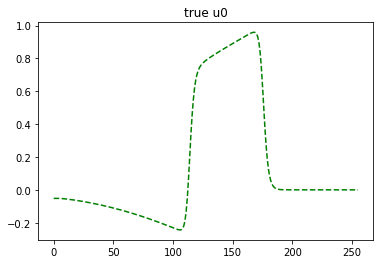

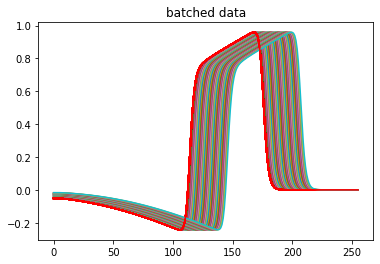

In [13]:
batch_u0, batch_u, batch_t, s = get_batch()
batch_element = 2
i = s[batch_element]
plt.figure()
plt.title('true u0')
plt.plot(train_data[i,:,:].flatten(),'--g',label='true_u0')
plt.figure()
plt.title('batched data')
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].flatten())
  plt.plot(batch_u0[batch_element,:,:].flatten(),'-r',label='u0')

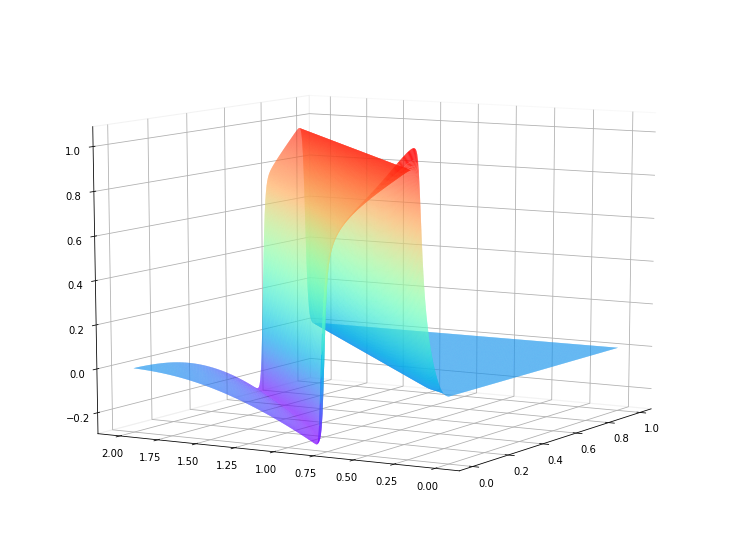

In [15]:
t = np.linspace(0, 2, 400)
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = train_data.squeeze(1).numpy()
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000,alpha=1)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(10, 210)

In [16]:
batch_u0.shape

torch.Size([16, 1, 256])

In [17]:
input = batch_u0
output = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same')(input)
output = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding='same')(output)
#output = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=1)(output)
output.shape


torch.Size([16, 1, 256])

In [18]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(256, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 256)
        )

        
        self.nfe=0
        self.net[0].weight.data.normal_(0.0, 1/n_hidden)
        self.net[0].bias.data.fill_(.0)
        self.net[2].weight.data.normal_(0.0, 1/n_hidden)
        self.net[2].bias.data.fill_(.0)

    def forward(self, t, y):
        self.nfe += 1
        return self.net(y)

In [22]:
class ConvODEFunc(nn.Module):
    def __init__(self):
        super(ConvODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same'),
            nn.ELU(),
            nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding='same'),
        )
        self.net[0].weight.data.normal_(0.0, 2/n_hidden)
        self.net[0].bias.data.fill_(.0)
        self.net[2].weight.data.normal_(0.0, 2/n_hidden)
        self.net[2].bias.data.fill_(.0)
        
    def forward(self, t, y):
        return self.net(y)

In [23]:
func = ConvODEFunc().to(device)

In [24]:
ii = 0
lrate = 1e-3


optimizer = optim.Adam(func.parameters(), lr=lrate)

loss_array = []
itr_time = []
start = time.time()

for itr in range(1, epochs + 1):

    start_itr = time.time()

    batch_u0, batch_u, batch_t, s = get_batch()
    pred_u = odeint(func, batch_u0, batch_t,method=method).to(device)
    
    loss = torch.mean(torch.pow(pred_u - batch_u,2))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    itr_time.append(time.time()-start_itr)
    loss_array.append(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            print('Iter ' + str(itr)+'/'+str(epochs) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5)))
            #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
            #       ii += 1

total_elapsed_time = time.time()-start

Iter 50/1000	|  Loss: 0.042285	|  lr: 0.001	|  itr time: 0.33695
Iter 100/1000	|  Loss: 0.025229	|  lr: 0.001	|  itr time: 0.71548
Iter 150/1000	|  Loss: 0.011909	|  lr: 0.001	|  itr time: 1.15019
Iter 200/1000	|  Loss: 0.007513	|  lr: 0.001	|  itr time: 0.91878
Iter 250/1000	|  Loss: 0.011677	|  lr: 0.001	|  itr time: 0.95127
Iter 300/1000	|  Loss: 0.009496	|  lr: 0.001	|  itr time: 0.91834
Iter 350/1000	|  Loss: 0.010345	|  lr: 0.001	|  itr time: 0.85723
Iter 400/1000	|  Loss: 0.008848	|  lr: 0.001	|  itr time: 0.93688
Iter 450/1000	|  Loss: 0.010438	|  lr: 0.001	|  itr time: 0.92388
Iter 500/1000	|  Loss: 0.008572	|  lr: 0.001	|  itr time: 0.87916
Iter 550/1000	|  Loss: 0.007761	|  lr: 0.001	|  itr time: 0.89938
Iter 600/1000	|  Loss: 0.007854	|  lr: 0.001	|  itr time: 0.90445
Iter 650/1000	|  Loss: 0.005785	|  lr: 0.001	|  itr time: 0.88484
Iter 700/1000	|  Loss: 0.007934	|  lr: 0.001	|  itr time: 0.90086
Iter 750/1000	|  Loss: 0.004781	|  lr: 0.001	|  itr time: 0.9056
Iter 800/100

In [25]:
batch_u0, batch_u, batch_t, s = get_batch_test(100,200)
batch_u0.shape, batch_u.shape, batch_t.shape
pred_u = odeint(func, batch_u0, batch_t,method=method).to(device)   

In [26]:
batch_u.shape

torch.Size([200, 1, 1, 256])

<Figure size 432x288 with 0 Axes>

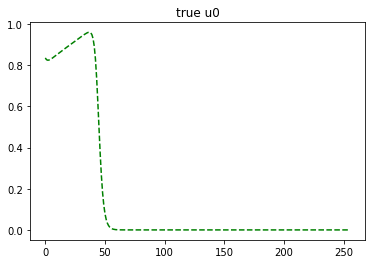

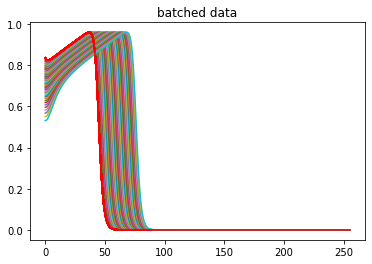

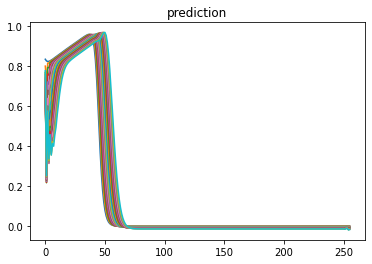

In [27]:
plt.figure().patch.set_facecolor('#FFFFFF')

batch_element = 0
i = s[batch_element]
plt.figure()
plt.title('true u0')
plt.plot(train_data[i,:,:].flatten(),'--g',label='true_u0')
plt.figure()
plt.title('batched data')
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].flatten())
  plt.plot(batch_u0[batch_element,:,:].flatten(),'-r',label='u0')
plt.savefig('target.png',dpi=200)

plt.figure()
plt.title('prediction')
for j in range(20):
  plt.plot(pred_u[j,batch_element,:,:].detach().flatten())

plt.savefig('pred.png',dpi=200)
#print(params_train_data[i])

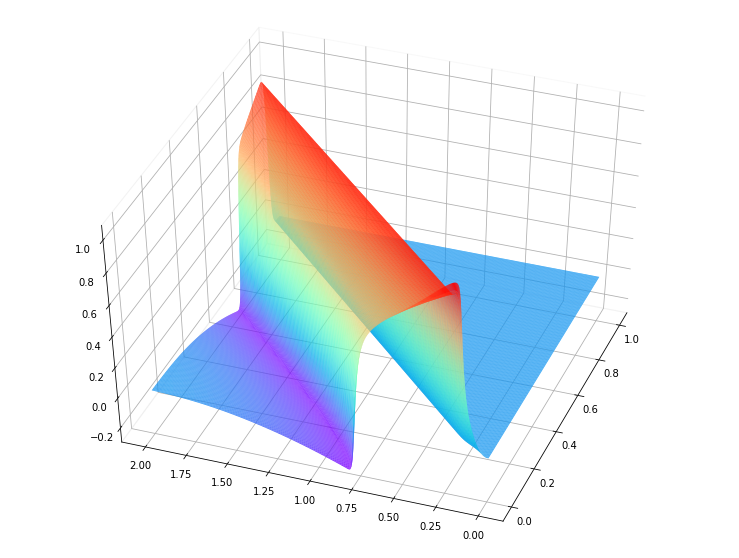

In [28]:
t = np.linspace(0, 2, 400)
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = train_data.squeeze(1).numpy()
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(45, 200)

In [29]:
pred_u.shape

torch.Size([100, 1, 1, 256])

In [ ]:
t0 = 300
pred_t = torch.arange(400-t0).float()
pred_u0 = train_data[t0,:,:].unsqueeze(0).float()
pred_u0.shape

In [55]:
pred_u = odeint(func, pred_u0, pred_t,method=method).to(device)   

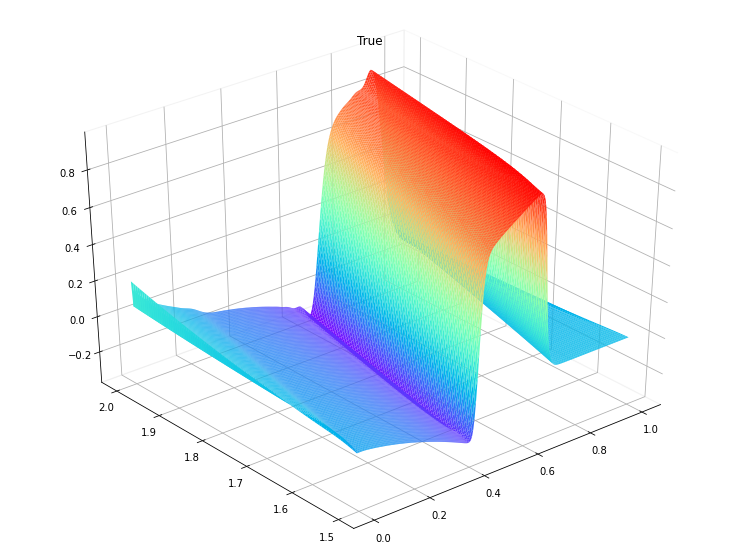

In [57]:
t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = pred_u.squeeze(1).squeeze(1).detach().numpy()
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('True')
ax.view_init(35, 230)

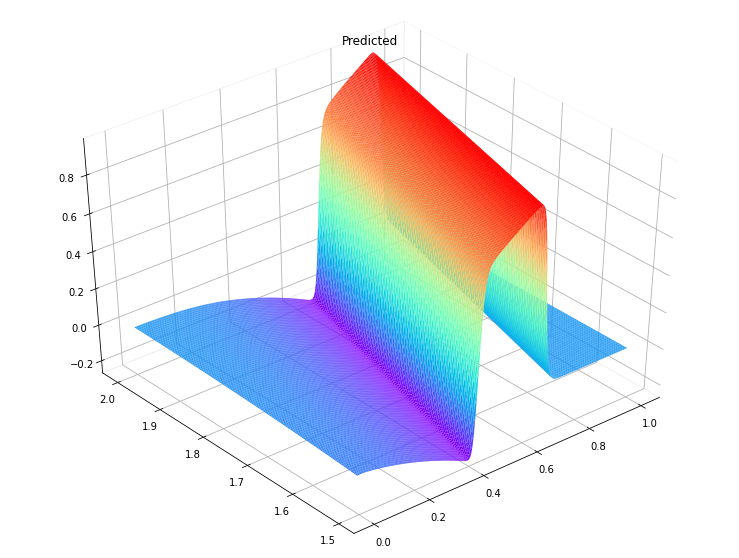

In [53]:
t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = train_data[t0:,:].squeeze(1).numpy()
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('Predicted')
ax.view_init(40, 230)

<Figure size 432x288 with 0 Axes>

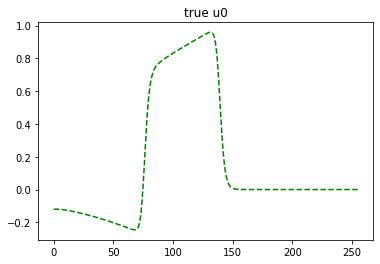

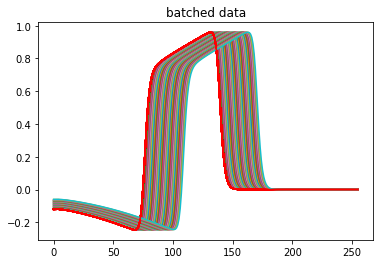

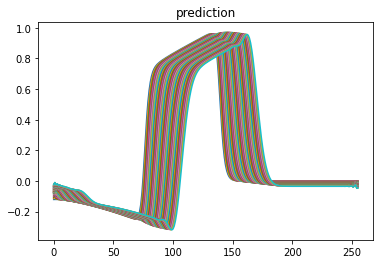

In [46]:
batch_u0, batch_u, batch_t, s = get_batch()
batch_u0.shape, batch_u.shape, batch_t.shape
pred_u = odeint(func, batch_u0, batch_t,method=method).to(device)   

plt.figure().patch.set_facecolor('#FFFFFF')

batch_element = 2
i = s[batch_element]
plt.figure()
plt.title('true u0')
plt.plot(train_data[i,:,:].flatten(),'--g',label='true_u0')
plt.figure()
plt.title('batched data')
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].flatten())
  plt.plot(batch_u0[batch_element,:,:].flatten(),'-r',label='u0')
plt.savefig('target.png',dpi=200)

plt.figure()
plt.title('prediction')
for j in range(batch_time):
  plt.plot(pred_u[j,batch_element,:,:].detach().flatten())

plt.savefig('pred.png',dpi=200)
#print(params_train_data[i])